In [16]:
import skimage.io
import skimage.filters
import skimage.draw
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy import ndimage
import cv2
import scipy.spatial.distance
import imutils
%matplotlib inline

img = skimage.io.imread('../img/grids/img.jpg')

# Binarisation de l'image
Nous allons essayer de binariser la photo du sudoku afin d'obtenir une image en noir et blanc.
Nous allons comparer deux méthodes de binarisation. Celle de Niblack et celle de Sauvola.

In [17]:
width, height, _ = img.shape

grey_img = skimage.color.rgb2gray(img.copy())

## Binarisation de Sauvola

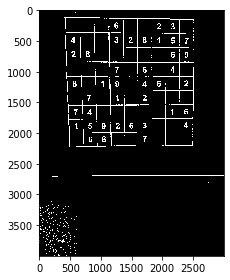

In [18]:
threshold_image = skimage.filters.threshold_sauvola(grey_img, window_size=71, k=0.1)

sauvola_result = np.where(grey_img < threshold_image, np.ones((width, height)), 0)

skimage.io.imshow(sauvola_result)
plt.show()

In [19]:
binarized_img = sauvola_result.astype('uint8')
cnts = cv2.findContours(binarized_img.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

puzzleCnt = None
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx) == 4:
        puzzleCnt = approx.reshape((4, 2)).astype('float32')
        break

print(puzzleCnt)

[[ 413.  110.]
 [ 493. 2228.]
 [2497. 2207.]
 [2516.  144.]]


In [20]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

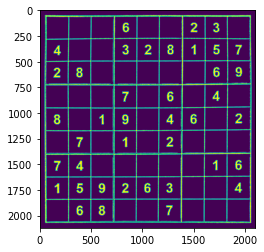

In [21]:
(tl, bl, br, tr) = puzzleCnt
rect = np.array([tl, tr, br, bl])
distances = scipy.spatial.distance.cdist(rect, rect)

maxWidth = max(int(distances[0, 1]), int(distances[2, 3]))
maxHeight = max(int(distances[0, 3]), int(distances[2, 3]))

margin = 50

dst = np.array([
    [margin, margin],
    [maxWidth - margin, margin],
    [maxWidth - margin, maxHeight - margin], 
    [margin, maxHeight - margin]], dtype = "float32")
    
M = cv2.getPerspectiveTransform(rect, dst)
sauvola_result = cv2.warpPerspective(sauvola_result, M, (maxWidth, maxHeight))

plt.imshow(sauvola_result)
plt.show()

# Détection de la grille
## Filtrage de l'image

c:\Users\km169\Desktop\Cours\Data mining\Projet de session\sudoku-reader\env\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


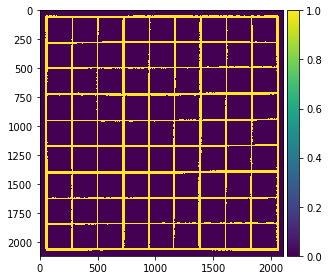

In [22]:
filtered_img = ndimage.binary_dilation(sauvola_result, iterations=3).astype(sauvola_result.dtype)

labeled_img, nb_labels = ndimage.label(filtered_img)

sizes = ndimage.sum(filtered_img, labeled_img, range(nb_labels + 1))
mask = sizes == max(sizes)

filtered_img = mask[labeled_img]
filtered_img = np.where(filtered_img == True, filtered_img, 0)
filtered_img = np.where(filtered_img == 0, filtered_img, 1)


skimage.io.imshow(filtered_img)

## Projections sur les différents axes

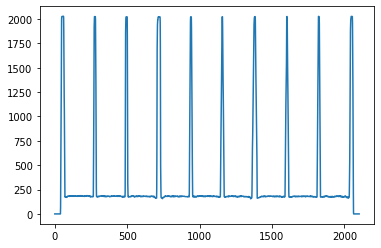

In [23]:
x_proj = filtered_img.sum(axis=0)
plt.plot(np.arange(len(x_proj)), x_proj)
plt.show()

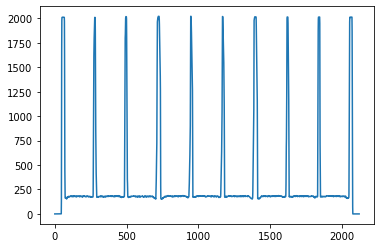

In [24]:
y_proj = filtered_img.sum(axis=1)
plt.plot(np.arange(len(y_proj)), y_proj)
plt.show()

## Reconnaissance de la grille

In [25]:
def clear_spikes(binary_picture: np.ndarray, spikes, axis=0):
    grid_width = spikes[-1]-spikes[0]
    margin = int(grid_width*0.025)
    proj = binary_picture.sum(axis=axis)
    for i in range(len(spikes)):
        spike = spikes[i]
        lower_bound = max(0, spike - margin)
        upper_bound = min(spike + margin, len(proj))
        spikes[i] = lower_bound + np.argmax(proj[lower_bound:upper_bound])
    return spikes

### Selon l'axe X

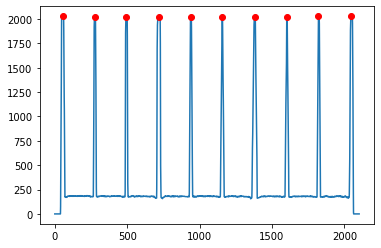

In [26]:
x_diff = np.diff(x_proj)
spikes = argrelextrema(x_diff, np.greater, order=int(len(x_diff)*.8*.05))[0] + 1

spikes = clear_spikes(filtered_img, spikes, axis=0)

# R&cupération des x plus grand pics
highest_spikes = spikes[np.argpartition(x_proj[spikes], -min(10, len(spikes)))[-min(10, len(spikes)):]]
x_spikes = np.sort(highest_spikes)

# Affichage de la nouvelle grille
plt.plot(np.arange(len(x_proj)), x_proj)
plt.plot(x_spikes, x_proj[x_spikes], 'ro')
plt.show()

### Selon l'axe Y

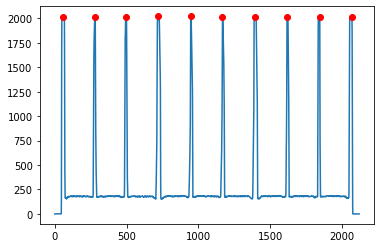

In [27]:
y_diff = np.diff(y_proj)
spikes = argrelextrema(y_diff, np.greater, order=int(len(y_diff)*.8*.05))[0] + 1

spikes = clear_spikes(filtered_img, spikes, axis=1)

# R&cupération des x plus grand pics
highest_spikes = spikes[np.argpartition(y_proj[spikes], -min(10, len(spikes)))[-min(10, len(spikes)):]]
y_spikes = np.sort(highest_spikes)

# Affichage de la nouvelle grille
plt.plot(np.arange(len(y_proj)), y_proj)
plt.plot(y_spikes, y_proj[y_spikes], 'ro')
plt.show()

# Isolation des cases

In [28]:
cells = list()

for i in range(len(y_spikes)-1):
    for j in range(len(x_spikes)-1):
        cells.append((x_spikes[j], x_spikes[j+1], y_spikes[i], y_spikes[i+1]))

print(f"{len(cells)} cases.")

81 cases.


## Détection des cases vides

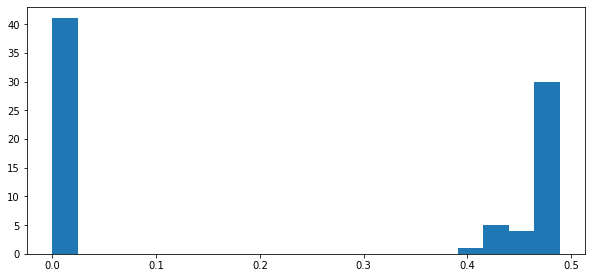

In [29]:
std_list = list()

cell_width = y_spikes[1]-y_spikes[0]
margin = int(cell_width*0.1)

for coor in cells:
    bin_cell = sauvola_result[coor[2] + 3*margin:coor[3] - 3*margin, coor[0] + 3*margin:coor[1] - 3*margin]
    std_list.append(np.std(bin_cell.flatten()))

plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.hist(std_list, 20)
plt.show()

## Mise en forme des chiffres détectés

40 cases avec des chiffres.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

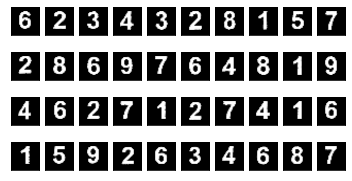

In [30]:
digits = list()
for i in range(len(std_list)):
    if std_list[i] > .3:
        digits.append(cells[i])

print(f"{len(digits)} cases avec des chiffres.")

i = 0


for coor in digits:
    img = sauvola_result[coor[2]+margin:coor[3]-margin, coor[0]+margin:coor[1]-margin]
    img = skimage.transform.resize(img, (32, 32), anti_aliasing=False)

    labeled_img, nb_labels = ndimage.label(img)
    sizes = ndimage.sum_labels(img, labeled_img, range(nb_labels + 1))

    digit_label = np.argmax(sizes)

    digit_slice = ndimage.find_objects(labeled_img == digit_label)[0]

    img = img[digit_slice]

    template = np.zeros((28, 28))

    digit_width, digit_height = img.shape
    padding_x = int((28 - digit_width) / 2)
    padding_y = int((28 - digit_height) / 2)

    template[padding_x:padding_x+digit_width, padding_y:padding_y+digit_height] = img

    img = template

    skimage.io.imsave(f'../img/cells/{i}.png', img)
    plt.subplot(5,10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.gray)
    i += 1